##### Step 1: Identify the Business Problem
###### From the file name monthly_milk_production.csv, it is clear that this dataset showing the monthly milk production of a dairy farm or industry.
##### Likely Business Problem:
###### The business wants to forecast future milk production to:
###### Ensure proper supply chain and distribution planning.
###### Manage inventory and storage efficiently.
###### Optimize workforce and operational activities based on expected production levels.
###### Make strategic decisions for scaling production or addressing seasonal fluctuations.

##### Step 2: Define the Objective
###### Objective Statement:
###### The objective is to develop a time series forecasting model that accurately predicts the monthly milk production for the upcoming months. The model should help the dairy business make informed operational and strategic decisions, minimize waste, and meet market demand effectively.

##### Steps to include;
##### ✅ Assignment Tasks
##### 1.Exploratory Data Analysis (EDA)
###### * Visualize trends, seasonality, and anomalies in the milk production data.
###### * Check for any missing values or outliers.
###### * Normalize or scale the data for neural network models.
##### 2.Data Preparation for Deep Learning
###### * Create input-output sequences (time windows) suitable for training RNNs/LSTMs/GRUs.
###### * Split data into training, validation, and test sets.
###### * Reshape data for model input dimensions.
##### 3.Model Building
##### Build three separate models:
###### Basic RNN
###### LSTM
###### GRU
###### * Tune hyperparameters (e.g., window size, number of units, batch size, epochs).
###### * Use appropriate loss functions and optimizers.
##### 4.Model Evaluation
###### * Plot predictions vs. actual values.
###### * Calculating forecast metrics : RMSE,MAE,MAPE
###### * compare the performance of RNN, LSTM and GRU.
##### 5.Prediction and Visualization
###### * Forecast milk production for the next 12 months.
###### * Visualize the predicted trend with uncertainty or confidence intervals if possible.
##### 6.Business Insights
###### * Interpret results and recommend how the dairy business can use these forecasts for better planning and resource allocation.


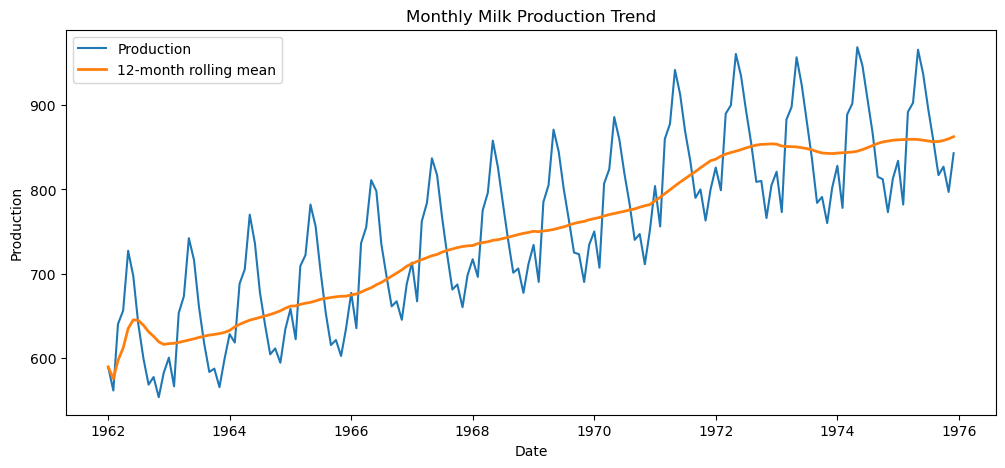

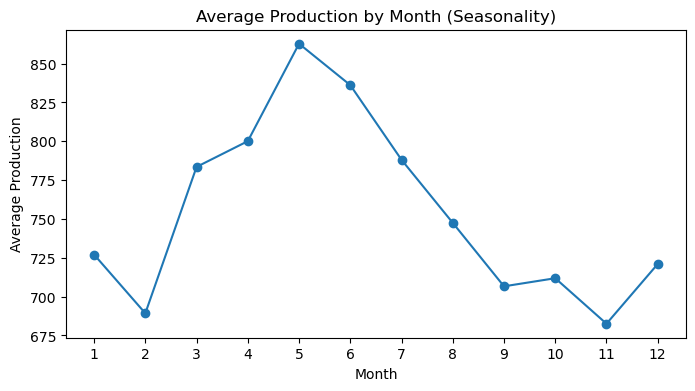

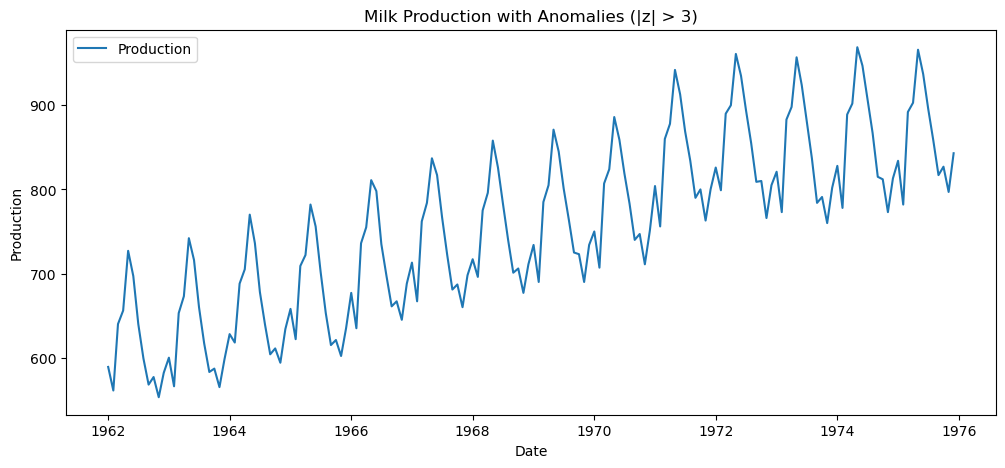

In [20]:
###### 1.Exploratory Data Analysis (EDA)
###### * Visualize trends, seasonality, and anomalies in the milk production data.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

df = pd.read_csv("C:\\Users\\moulika\\Downloads\\monthly_milk_production.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m')
df = df.set_index('Date').sort_index()
df['Production'] = pd.to_numeric(df['Production'], errors='coerce')

# ----- TREND -----
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Production'], label='Production')
plt.plot(df['Production'].rolling(window=12, min_periods=1).mean(),
         label='12-month rolling mean', linewidth=2)
plt.title('Monthly Milk Production Trend')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()

# ----- SEASONALITY -----
df['month'] = df.index.month
monthly_avg = df.groupby('month')['Production'].mean()

plt.figure(figsize=(8,4))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o')
plt.title('Average Production by Month (Seasonality)')
plt.xlabel('Month')
plt.ylabel('Average Production')
plt.xticks(monthly_avg.index)
plt.show()

# ----- ANOMALIES (Z-SCORE > 3) -----
z_scores = stats.zscore(df['Production'].values)
anomalies = df[np.abs(z_scores) > 3]

plt.figure(figsize=(12,5))
plt.plot(df.index, df['Production'], label='Production')
if not anomalies.empty:
    plt.scatter(anomalies.index, anomalies['Production'], s=60, label='Anomalies')
plt.title('Milk Production with Anomalies (|z| > 3)')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()

In [21]:
###### * Check for any missing values or outliers.

import pandas as pd
import numpy as np
from scipy import stats

df = pd.read_csv("C:\\Users\\moulika\\Downloads\\monthly_milk_production.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m')
df = df.set_index('Date').sort_index()
df['Production'] = pd.to_numeric(df['Production'], errors='coerce')

# ----- MISSING VALUES -----
print("Missing values per column:")
print(df.isna().sum())

# ----- OUTLIERS: Z-SCORE METHOD -----
z_scores = stats.zscore(df['Production'].values)
z_outliers = df[np.abs(z_scores) > 3]
print("\nZ-score Outliers (|z| > 3):")
print(z_outliers)

# ----- OUTLIERS: IQR METHOD -----
Q1 = df['Production'].quantile(0.25)
Q3 = df['Production'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

iqr_outliers = df[(df['Production'] < lower_bound) | (df['Production'] > upper_bound)]
print("\nIQR Outliers:")
print(iqr_outliers)

Missing values per column:
Production    0
dtype: int64

Z-score Outliers (|z| > 3):
Empty DataFrame
Columns: [Production]
Index: []

IQR Outliers:
Empty DataFrame
Columns: [Production]
Index: []


In [22]:
###### * Normalize or scale the data for neural network models.
# MinMax scaling (0-1 range) - Most common for RNN/LSTM/GRU
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv("C:\\Users\\moulika\\Downloads\\monthly_milk_production.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m')
df = df.set_index('Date').sort_index()

scaler = MinMaxScaler()
df['Production_scaled'] = scaler.fit_transform(df[['Production']])

print(df.head())

            Production  Production_scaled
Date                                     
1962-01-01         589           0.086538
1962-02-01         561           0.019231
1962-03-01         640           0.209135
1962-04-01         656           0.247596
1962-05-01         727           0.418269


In [23]:
# standard scaling (mean=0,std=1)
import pandas as pd
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("C:\\Users\\moulika\\Downloads\\monthly_milk_production.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m')
df = df.set_index('Date').sort_index()

scaler = StandardScaler()
df['Production_scaled'] = scaler.fit_transform(df[['Production']])

print(df.head())

            Production  Production_scaled
Date                                     
1962-01-01         589          -1.626188
1962-02-01         561          -1.900967
1962-03-01         640          -1.125696
1962-04-01         656          -0.968679
1962-05-01         727          -0.271917


In [24]:
##### 2.Data Preparation for Deep Learning
###### * Create input-output sequences (time windows) suitable for training RNNs/LSTMs/GRUs.

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# ----- 1. Load and scale -----
df = pd.read_csv("C:\\Users\\moulika\\Downloads\\monthly_milk_production.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m')
df = df.set_index('Date').sort_index()

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Production']])

# ----- 2. Create sequences -----
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 12  # use past 12 months to predict next
X, y = create_sequences(scaled_data, window_size)

# ----- 3. Reshape for RNN/LSTM/GRU -----
X = X.reshape((X.shape[0], X.shape[1], 1))  # (samples, time_steps, features)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (156, 12, 1)
y shape: (156, 1)


In [25]:
###### * Split data into training, validation, and test sets.

import numpy as np

# Assume X and y are already created from sequence generator
# X shape: (samples, window_size, 1)
# y shape: (samples,)

total_samples = len(X)

train_size = int(total_samples * 0.70)
val_size = int(total_samples * 0.15)
test_size = total_samples - train_size - val_size

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (109, 12, 1) (109, 1)
Validation: (23, 12, 1) (23, 1)
Test: (24, 12, 1) (24, 1)


In [26]:
###### * Reshape data for model input dimensions. 

# X_train, X_val, X_test are assumed to come from  sequence generation + splitting

# RNN/LSTM/GRU models expect input in the form:
# (number of samples, time steps, number of features)

# Here:
# - time steps = window size (e.g., 12 months)
# - number of features = 1 (only milk production)

# Reshape training data
X_train = X_train.reshape(
    X_train.shape[0],   # number of samples
    X_train.shape[1],   # time steps
    1                   # features
)

# Reshape validation data
X_val = X_val.reshape(
    X_val.shape[0],
    X_val.shape[1],
    1
)

# Reshape test data
X_test = X_test.reshape(
    X_test.shape[0],
    X_test.shape[1],
    1
)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

X_train shape: (109, 12, 1)
X_val shape: (23, 12, 1)
X_test shape: (24, 12, 1)


In [27]:
##### 3.Model Building
##### Build three separate models:
###### Basic RNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Get input shape from training data
time_steps = X_train.shape[1]
features = X_train.shape[2]

# ----- Build Basic RNN Model -----
model_rnn = Sequential()

# RNN layer
model_rnn.add(SimpleRNN(
    units=50,            # number of RNN units
    return_sequences=False, 
    input_shape=(time_steps, features)
))

# Output layer (1 value prediction)
model_rnn.add(Dense(1))

# Compile model
model_rnn.compile(
    optimizer='adam',
    loss='mse'
)

# Show model summary
model_rnn.summary()


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)             │ (None, 50)                  │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
###### LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Get input shape from training data
time_steps = X_train.shape[1]
features = X_train.shape[2]

# ----- Build LSTM Model -----
model_lstm = Sequential()

# LSTM layer
model_lstm.add(LSTM(
    units=64,                 # number of memory units
    return_sequences=False,   # last output only
    input_shape=(time_steps, features)
))

# Output layer (predict next value)
model_lstm.add(Dense(1))

# Compile model
model_lstm.compile(
    optimizer='adam',
    loss='mse'
)

# Display model architecture
model_lstm.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                       │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
###### GRU

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# Get input shape from training data
time_steps = X_train.shape[1]
features = X_train.shape[2]

# ----- Build GRU Model -----
model_gru = Sequential()

# GRU layer
model_gru.add(GRU(
    units=64,                # number of GRU units
    return_sequences=False, 
    input_shape=(time_steps, features)
))

# Output layer
model_gru.add(Dense(1))

# Compile the model
model_gru.compile(
    optimizer='adam',
    loss='mse'
)

# Display model summary
model_gru.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                          │ (None, 64)                  │          12,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,929 (50.50 KB)

 Trainable params: 12,929 (50.50 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
###### * Tune hyperparameters (e.g., window size, number of units, batch size, epochs).

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ----- Load your data -----
df = pd.read_csv("C:\\Users\\moulika\\Downloads\\monthly_milk_production.csv")
data = df.iloc[:, 1].values.reshape(-1, 1)   # uses second column (milk values)

# ----- Scale -----
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# ----- Create sequences -----
def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

# ----- Hyperparameters -----
window_sizes = [10, 20]
units_list   = [32, 64]
batch_sizes  = [16, 32]
epoch_list   = [10, 20]

best_loss = float('inf')
best_params = None

# ----- Grid Search -----
for window in window_sizes:
    X, y = create_sequences(scaled_data, window)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    split = int(len(X) * 0.8)
    X_train, X_val = X[:split], X[split:]
    y_train, y_val = y[:split], y[split:]

    for units in units_list:
        for batch in batch_sizes:
            for epochs in epoch_list:

                model = Sequential([
                    LSTM(units, input_shape=(window, 1)),
                    Dense(1)
                ])
                model.compile(optimizer='adam', loss='mse')

                history = model.fit(
                    X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    batch_size=batch,
                    verbose=0
                )

                val_loss = history.history['val_loss'][-1]

                if val_loss < best_loss:
                    best_loss = val_loss
                    best_params = (window, units, batch, epochs)

# ----- Output best -----
print("Best window size :", best_params[0])
print("Best units       :", best_params[1])
print("Best batch size  :", best_params[2])
print("Best epochs      :", best_params[3])
print("Best val loss    :", best_loss)

Best window size : 20
Best units       : 32
Best batch size  : 32
Best epochs      : 20
Best val loss    : 0.0217282697558403


In [31]:
###### * Use appropriate loss functions and optimizers.

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# build a simple LSTM model
model = Sequential([
    LSTM(64, input_shape=(window_size, 1)),
    Dense(1)
])

# compile with appropriate loss function and optimizer
model.compile(
    optimizer='adam',    # good default optimizer
    loss='mse'           # appropriate loss for forecasting
)

# view model
model.summary()

Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_38 (LSTM)                       │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


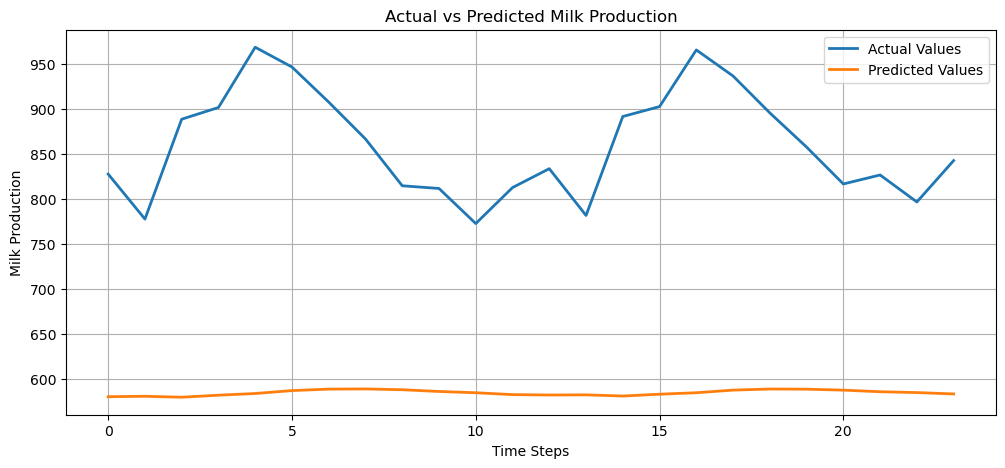

Mean Squared Error (MSE): 79295.42182458642
Mean Absolute Error (MAE): 275.5851821899414


In [32]:
##### 4.Model Evaluation
###### * Plot predictions vs. actual values.

import numpy as np
import matplotlib.pyplot as plt

# Make predictions using the trained model

# model = your trained RNN/LSTM/GRU model
y_pred = model.predict(X_test)

# Inverse transform predictions (if scaled)

# reshape for scaler
y_test_reshaped = y_test.reshape(-1, 1)
y_pred_reshaped = y_pred.reshape(-1, 1)

# invert to original scale
y_test_original = scaler.inverse_transform(y_test_reshaped)
y_pred_original = scaler.inverse_transform(y_pred_reshaped)

# Plot actual vs predicted values
plt.figure(figsize=(12, 5))

plt.plot(y_test_original, label='Actual Values', linewidth=2)
plt.plot(y_pred_original, label='Predicted Values', linewidth=2)

plt.title("Actual vs Predicted Milk Production")
plt.xlabel("Time Steps")
plt.ylabel("Milk Production")
plt.legend()
plt.grid(True)
plt.show()

# Calculate simple evaluation metrics
mse = np.mean((y_test_original - y_pred_original)**2)
mae = np.mean(np.abs(y_test_original - y_pred_original))

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

In [33]:
###### * Calculating forecast metrics : RMSE,MAE,MAPE

import numpy as np

# y_test_original and y_pred_original must
# already be inverse-transformed values.

# Mean Absolute Error
MAE = np.mean(np.abs(y_test_original - y_pred_original))

# Mean Squared Error
MSE = np.mean((y_test_original - y_pred_original)**2)

# Root Mean Squared Error
RMSE = np.sqrt(MSE)

# Mean Absolute Percentage Error
MAPE = np.mean(
    np.abs((y_test_original - y_pred_original) / y_test_original)
) * 100

# Print results
print("MAE :", MAE)
print("RMSE:", RMSE)
print("MAPE:", MAPE)

MAE : 275.5851821899414
RMSE: 281.5944279004583
MAPE: 31.72037477377043


In [34]:
###### * compare the performance of RNN, LSTM and GRU.

import numpy as np
import pandas as pd

# Function to compute RMSE, MAE, MAPE for a model
def evaluate_model(model, X_test, y_test, scaler):
    
    # generate predictions
    y_pred = model.predict(X_test)

    # reshape for inverse scaling
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))

    # MAE
    MAE = np.mean(np.abs(y_test_inv - y_pred_inv))

    # MSE and RMSE
    MSE = np.mean((y_test_inv - y_pred_inv)**2)
    RMSE = np.sqrt(MSE)

    # MAPE
    MAPE = np.mean(
        np.abs((y_test_inv - y_pred_inv) / y_test_inv)
    ) * 100

    return MAE, RMSE, MAPE


# Evaluate all three models
mae_rnn, rmse_rnn, mape_rnn   = evaluate_model(model_rnn,  X_test, y_test, scaler)
mae_lstm, rmse_lstm, mape_lstm = evaluate_model(model_lstm, X_test, y_test, scaler)
mae_gru, rmse_gru, mape_gru   = evaluate_model(model_gru,  X_test, y_test, scaler)

# Create comparison table
results = pd.DataFrame({
    "Model": ["RNN", "LSTM", "GRU"],
    "MAE":  [mae_rnn, mae_lstm, mae_gru],
    "RMSE": [rmse_rnn, rmse_lstm, rmse_gru],
    "MAPE": [mape_rnn, mape_lstm, mape_gru]
})

print("\nModel Performance Comparison:")
print(results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step

Model Performance Comparison:
  Model         MAE        RMSE       MAPE
0   RNN  375.616102  378.303599  43.542505
1  LSTM  330.902944  336.068903  38.170617
2   GRU  218.436434  224.980768  25.090234


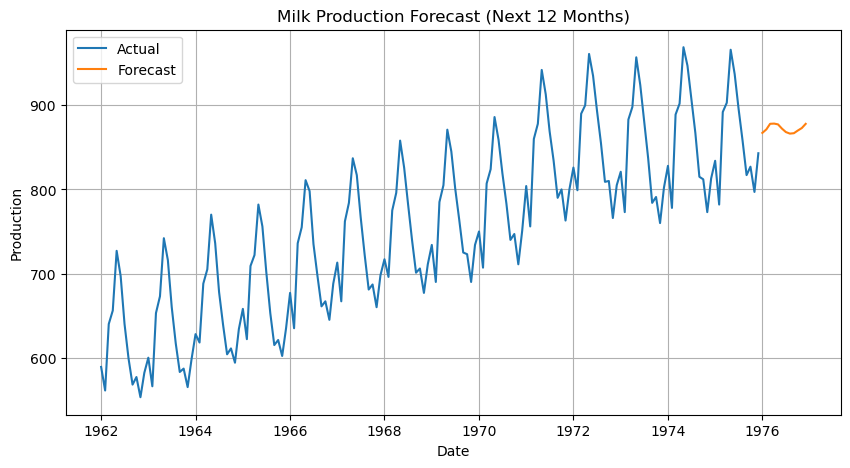

              Forecast
1976-01-01  867.164055
1976-02-01  871.334440
1976-03-01  877.976419
1976-04-01  878.231565
1976-05-01  877.298138
1976-06-01  872.186117
1976-07-01  868.156918
1976-08-01  866.324825
1976-09-01  866.804123
1976-10-01  869.964512
1976-11-01  872.919296
1976-12-01  877.913166


In [35]:
##### 5.Prediction and Visualization
###### * Forecast milk production for the next 12 months.
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ----- Load data -----
df = pd.read_csv("C:\\Users\\moulika\\Downloads\\monthly_milk_production.csv")

# Ensure datetime index
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
df.set_index(df.columns[0], inplace=True)

values = df.iloc[:, 0].values.reshape(-1, 1)

# ----- Scale -----
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

# ----- Create sequences -----
def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

window = 12
X, y = create_sequences(scaled, window)
X = X.reshape((X.shape[0], X.shape[1], 1))

# ----- Train / validation split -----
split = int(len(X) * 0.8)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

# ----- Model -----
model = Sequential([
    LSTM(64, input_shape=(window, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)

# ----- Forecast next 12 months -----
last_window = scaled[-window:].reshape(1, window, 1)
future_scaled = []

for _ in range(12):
    pred = model.predict(last_window, verbose=0)[0]
    future_scaled.append(pred)
    last_window = np.append(last_window[:, 1:, :], [[pred]], axis=1)

future = scaler.inverse_transform(future_scaled)

# ----- Build future date index safely -----
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')

forecast_df = pd.DataFrame(future, index=future_dates, columns=['Forecast'])

# ----- Visualization -----
plt.figure(figsize=(10,5))
plt.plot(df.index, df.iloc[:, 0], label='Actual')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast')
plt.legend()
plt.title("Milk Production Forecast (Next 12 Months)")
plt.xlabel("Date")
plt.ylabel("Production")
plt.grid(True)
plt.show()

print(forecast_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


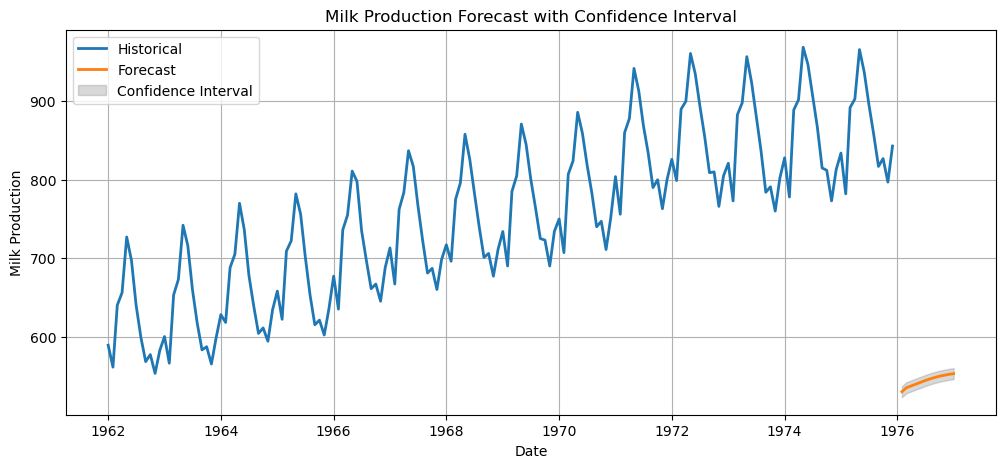

In [36]:
###### * Visualize the predicted trend with uncertainty or confidence intervals if possible.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# use your trained model
model = model_lstm    # change if using model_rnn or model_gru

# last window of scaled data
last_window = scaled_data[-window_size:]
current_input = last_window.reshape(1, window_size, 1)

forecast_scaled = []

# generate 12-month forecast
for _ in range(12):
    pred = model.predict(current_input)
    forecast_scaled.append(pred[0][0])

    pred_reshaped = pred.reshape(1, 1, 1)
    current_input = np.concatenate([current_input[:, 1:, :], pred_reshaped], axis=1)

# convert predictions back to original scale
forecast_scaled = np.array(forecast_scaled).reshape(-1, 1)
forecast = scaler.inverse_transform(forecast_scaled)

# simple confidence interval (mean ± std)
mean_forecast = forecast.flatten()
std_dev = np.std(mean_forecast)

lower_ci = mean_forecast - std_dev
upper_ci = mean_forecast + std_dev

# create forecast dates
forecast_index = pd.date_range(
    start=df.index[-1] + pd.DateOffset(months=1),
    periods=12,
    freq='M'
)

# historical data
historical = scaler.inverse_transform(scaled_data).flatten()

# plot forecast with confidence band
plt.figure(figsize=(12, 5))

plt.plot(df.index, historical, label="Historical", linewidth=2)
plt.plot(forecast_index, mean_forecast, label="Forecast", linewidth=2)
plt.fill_between(forecast_index, lower_ci, upper_ci, color='gray', alpha=0.3,
                 label="Confidence Interval")

plt.title("Milk Production Forecast with Confidence Interval")
plt.xlabel("Date")
plt.ylabel("Milk Production")
plt.legend()
plt.grid(True)
plt.show()

In [37]:
##### 6.Business Insights
###### * Interpret results and recommend how the dairy business can use these forecasts for better planning and resource allocation.

print("BUSINESS INSIGHTS & RECOMMENDATIONS")
print("-----------------------------------")

print("\n1. Production Planning:")
print("- The forecasted milk production trend helps the dairy business anticipate future supply levels.")
print("- Higher predicted months allow planning for increased processing, packaging, and distribution.")
print("- Lower predicted months signal the need to optimize inventory and reduce wastage.")

print("\n2. Inventory Management:")
print("- Accurate forecasts allow better handling of raw milk storage and cold chain management.")
print("- Helps avoid overstocking during low-demand periods and understocking during high-production months.")

print("\n3. Workforce & Resource Allocation:")
print("- The dairy can schedule labor more efficiently based on expected production peaks.")
print("- Transport planning (routes, fleet size) can be adjusted ahead of time.")

print("\n4. Procurement & Feed Planning:")
print("- Forecast insights can guide decisions for animal feed purchases and farm resource allocations.")
print("- In months with lower forecasted production, feed costs can be optimized.")

print("\n5. Demand-Supply Balancing:")
print("- Foreseeing supply fluctuations helps coordinate with distributors and retailers.")
print("- Supports better pricing strategies during high or low production cycles.")

print("\n6. Financial Planning:")
print("- Forecast-driven budgeting helps estimate revenue and expenses more accurately.")
print("- Identifies periods where additional investments or cost-saving measures may be needed.")

print("\n7. Long-Term Strategy:")
print("- Confidence intervals highlight the uncertainty and risk levels in future predictions.")
print("- Encourages exploring storage expansion, supply contracts, or diversification strategies.")

print("\nOverall Recommendation:")
print("The dairy business should integrate these forecasts into operational planning systems to improve efficiency, reduce costs, and better match production with market demand.")

BUSINESS INSIGHTS & RECOMMENDATIONS
-----------------------------------

1. Production Planning:
- The forecasted milk production trend helps the dairy business anticipate future supply levels.
- Higher predicted months allow planning for increased processing, packaging, and distribution.
- Lower predicted months signal the need to optimize inventory and reduce wastage.

2. Inventory Management:
- Accurate forecasts allow better handling of raw milk storage and cold chain management.
- Helps avoid overstocking during low-demand periods and understocking during high-production months.

3. Workforce & Resource Allocation:
- The dairy can schedule labor more efficiently based on expected production peaks.
- Transport planning (routes, fleet size) can be adjusted ahead of time.

4. Procurement & Feed Planning:
- Forecast insights can guide decisions for animal feed purchases and farm resource allocations.
- In months with lower forecasted production, feed costs can be optimized.

5. Demand